In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import emoji
import nltk
from nltk.stem import PorterStemmer
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.utils import class_weight as cw
import string
from nltk import pos_tag 
from keras.optimizers import Adam ,RMSprop
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization,add, Dropout, Flatten,Concatenate,GlobalAveragePooling1D
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.models import Model
from nltk.stem.isri import ISRIStemmer
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.text import Tokenizer 
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Embedding , LSTM ,GRU,Conv1D,GlobalMaxPooling1D,SpatialDropout1D,CuDNNLSTM,Bidirectional
from keras.layers.embeddings import Embedding

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['Tweets.csv']


In [3]:
tweets_path = '../input/Tweets.csv' #when forking the kernel just put the path for the csv file of the data on your os
df = pd.read_csv(tweets_path)

In [4]:
df.head()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,cairdin,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,jnardino,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


counting the labels frequancy, it is clear that the data is unbalanced ,but it's ok for now there we'll be methods to solve this.

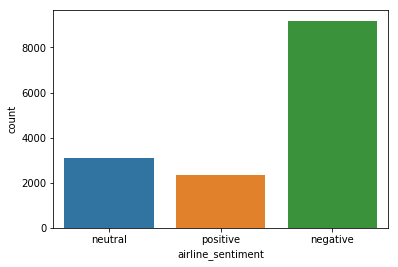

In [5]:
sns.countplot(df["airline_sentiment"])

defining inputs and output labels for the model 

In [6]:
X = df['text']
Y = df['airline_sentiment']

here i removed the negative stop words as they are somehow important ,after trying removing them accuracy increases sometimes

In [7]:
imp = ['against','not','don',"don't","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't","needn't","wasn't","weren't","wouldn't"]
stop_words = [w for w in stopwords.words('english') if w not in imp]

 **function for cleaning any text **
 
 i have tried to lemmatize and to stem the text it didn't improve the accuracy so after trying many operations to do on the text i decided not to lemmatize or stem also not to remove the stop words from the text

In [8]:
# def get_wordnet_pos(pos_tag):
#     if pos_tag.startswith('J'):
#         return wordnet.ADJ
#     elif pos_tag.startswith('V'):
#         return wordnet.VERB
#     elif pos_tag.startswith('N'):
#         return wordnet.NOUN
#     elif pos_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN
def clean_text(text):
    # lower text
    text = emoji.demojize(text) # demojize the emojis, emoji to text 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split()) #for removing the batterns
    text = text.lower() # lowering the text 
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    #stop = stop_words
    #text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    #pos tag text
    #pos_tags = pos_tag(text)
    # lemmatize text
    #text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    #ps = PorterStemmer() 
    #text = [ps.stem(t) for t in text]
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [9]:
X = X.apply(lambda x :clean_text(x)) #apply cleaning to every row in the data

In [10]:
X.head()

0                                            what said
1    plus you ve added commercials to the experienc...
2       didn today must mean need to take another trip
3    it really aggressive to blast obnoxious entert...
4                 and it really big bad thing about it
Name: text, dtype: object

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15) #splitting the data fpr train and test

Fitting CountVectorizer and TfidfVectorizer to the training data

In [12]:
vect = CountVectorizer(ngram_range=(1,2)).fit(X_train)
train_df_vectorized = vect.transform(X_train)
vect_tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=2,max_df=0.5).fit(X_train)
train_df_vectorized_tfidf = vect_tfidf.transform(X_train)


label encoding for the target output.

In [13]:
LB = LabelEncoder()
Y_train = LB.fit_transform(Y_train).reshape(-1, 1)
#Y_train = to_categorical(Y_train)
Y_test = LB.transform(Y_test).reshape(-1,1)


make the classes weighted so as to overcome the unbalancing in the data

In [14]:
def get_weight(y):#getting class_weights to make the data balanced
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current
class_weight = get_weight(Y_train.flatten())

**naive bayes classifier works well wih sentiment analysis, i have tried using it, also used SVM,naive bayes gave better accuracy .**
here i tried naive bayes with both count vectrizer and tfidf vectorizer both of them almost gave the same test accuracy .

In [15]:
clfrNB = MultinomialNB(alpha = 0.1)
clfrNB.fit(train_df_vectorized, Y_train)
clfrNB_tfidf = MultinomialNB(alpha = 0.1)
clfrNB_tfidf.fit(train_df_vectorized_tfidf, Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [16]:
acc_nb_tfidf = accuracy_score(clfrNB_tfidf.predict(vect_tfidf.transform(X_test)),Y_test),
acc_nb_cv = accuracy_score(clfrNB.predict(vect.transform(X_test)),Y_test)
print("accuracy using tfidf vectorizer and Naive Bayes model is: " +str(acc_nb_tfidf) )
print("accuracy using count vectorizer and Naive Bayes model is: " +str(acc_nb_cv) )

accuracy using tfidf vectorizer and Naive Bayes model is: (0.7877959927140255,)
accuracy using count vectorizer and Naive Bayes model is: 0.7987249544626593


**fitting SVM model **

it is also fitted using count and tfidf vectorzier 

In [17]:
from sklearn.svm import SVC
clf_svc = SVC()
clf_svc.fit(train_df_vectorized, Y_train)
clf_svc_tfidf = SVC()
clf_svc_tfidf.fit(train_df_vectorized_tfidf, Y_train)
acc_cv_svm = accuracy_score(Y_test,clf_svc.predict(vect.transform(X_test)))
acc_tfidf_svm = accuracy_score(Y_test,clf_svc_tfidf.predict(vect_tfidf.transform(X_test)))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

In [18]:
print("accuracy using tfidf vectorizer and SVM model is: " +str(acc_tfidf_svm) )
print("accuracy using count vectorizer and SVM model is: " +str(acc_cv_svm) )

accuracy using tfidf vectorizer and SVM model is: 0.6234061930783242
accuracy using count vectorizer and SVM model is: 0.6234061930783242


**preprocessing for sequence model**

In [20]:
max_words = len(set(" ".join(X_train).split())) #getting the number of unique words in the document
max_len = X_train.apply(lambda x: len(x)).max() #getting the longest sentence in the data

# max_words = 1000
# max_len = 150
max_words, max_len
tokenizer = Tokenizer(num_words=max_words)#initialize a tokenizer with max unique words in the text
tokenizer.fit_on_texts(X_train) 

X_train_seq = tokenizer.texts_to_sequences(X_train) #change every word to a unique number
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len) #pad the sentences ,to make every sentence have the same length


In [21]:
X_train_seq.shape,Y_train.shape

((12444, 558), (12444, 1))

**Structuring a deep learning model**

a deep learning model to do sentiment analysis ,here we may use RNN,LSTM,GRU... , but i have been trying using them and using one directional convolution , found one directional convolution gave better accuracy in this case.

In [22]:
EMBEDDDING_DIM = 100
model = Sequential()
model.add(Embedding(max_words,EMBEDDDING_DIM,input_length=max_len))
model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

compiling the model using adam optimizer simply this optimizer is a merge of two optimizers (momentum and Rmsprop),and simply those optimizers make the model reach the minimum faster.

In [23]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

using learning rate decay it is very effective in late epochs 

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.fit(X_train_seq,pd.Series(Y_train.reshape(-1)),epochs=30,batch_size = 1024,validation_split=0.2,callbacks=[learning_rate_reduction],class_weight =class_weight)

Train on 9955 samples, validate on 2489 samples
Epoch 1/30
9955/9955 [==============================] - 8s 824us/step - loss: 1.7155 - acc: 0.4173 - val_loss: 1.0281 - val_acc: 0.6312
Epoch 2/30
9955/9955 [==============================] - 3s 345us/step - loss: 1.4162 - acc: 0.5036 - val_loss: 0.9012 - val_acc: 0.6718
Epoch 3/30
9955/9955 [==============================] - 3s 344us/step - loss: 1.1757 - acc: 0.5536 - val_loss: 0.8092 - val_acc: 0.7031
Epoch 4/30
9955/9955 [==============================] - 3s 344us/step - loss: 1.0075 - acc: 0.6019 - val_loss: 0.7650 - val_acc: 0.7172
Epoch 5/30
9955/9955 [==============================] - 3s 345us/step - loss: 0.8796 - acc: 0.6519 - val_loss: 0.7277 - val_acc: 0.7300
Epoch 6/30
9955/9955 [==============================] - 3s 345us/step - loss: 0.7480 - acc: 0.7048 - val_loss: 0.7032 - val_acc: 0.7340
Epoch 7/30
9955/9955 [==============================] - 3s 344us/step - loss: 0.6616 - acc: 0.7440 - val_loss: 0.6811 - val_acc: 0.7380


0.7750100389260659

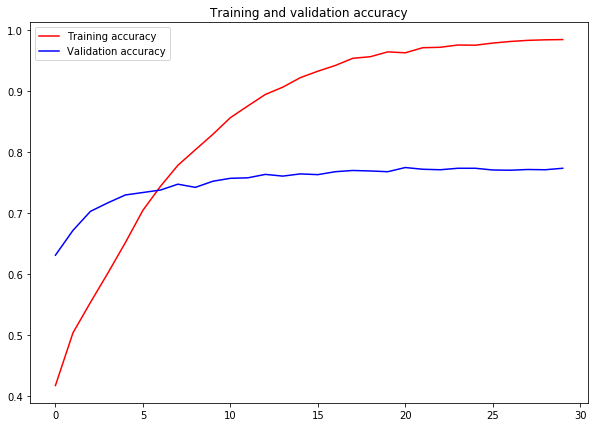

<Figure size 432x288 with 0 Axes>

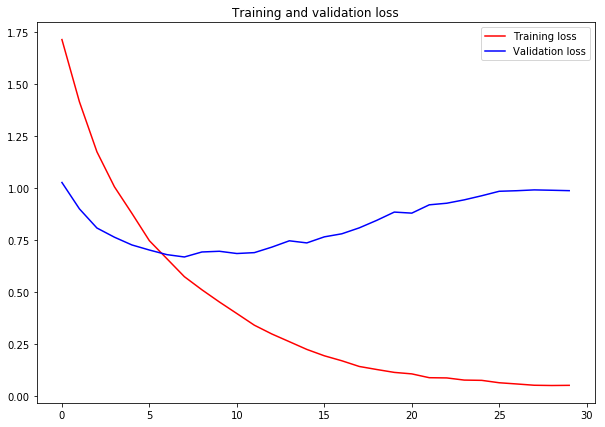

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
history = model.history
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy','Validation accuracy'])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.legend(['Training loss','Validation loss'])
plt.figure()
max(val_acc) #the best validation accuracy the model have got

In [35]:
test_X_seq = tokenizer.texts_to_sequences(X_test) 
test_X_seq = pad_sequences(test_X_seq, maxlen=max_len)
accuracy1 = model.evaluate(test_X_seq, Y_test)
print("accuracy of Embedding Conv1D model: " + str(accuracy1[1]))
print("maximum validation accuracy is: "+str(max(val_acc))+ " "+"at epoch " +str(val_acc.index(max(val_acc))))


2196/2196 [==============================] - 0s 117us/step
accuracy of Embedding Conv1D model: 0.7586520947176685
maximum validation accuracy is: 0.7717959013699814 at epoch 13


**GRU model with word embeddings **

In [27]:
EMBEDDDING_DIM = 150
model2 = Sequential()
model2.add(Embedding(max_words,EMBEDDDING_DIM,input_length=max_len))
model2.add(GRU(units=32,dropout=0.2,recurrent_dropout=0.2))
model2.add(Dense(3,activation='softmax'))

In [28]:
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [29]:
learning_rate_reduction3 = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model2.fit(X_train_seq,pd.Series(Y_train.reshape(-1)),epochs=15,batch_size = 1024,validation_split=0.2
           ,callbacks=[learning_rate_reduction3])

Train on 9955 samples, validate on 2489 samples
Epoch 1/15
9955/9955 [==============================] - 10s 996us/step - loss: 1.0646 - acc: 0.5706 - val_loss: 1.0170 - val_acc: 0.6356
Epoch 2/15
9955/9955 [==============================] - 9s 898us/step - loss: 0.9449 - acc: 0.6541 - val_loss: 0.8887 - val_acc: 0.6308
Epoch 3/15
9955/9955 [==============================] - 9s 894us/step - loss: 0.7975 - acc: 0.6583 - val_loss: 0.8115 - val_acc: 0.6424
Epoch 4/15
9955/9955 [==============================] - 9s 894us/step - loss: 0.7209 - acc: 0.6774 - val_loss: 0.7475 - val_acc: 0.6806
Epoch 5/15
9955/9955 [==============================] - 9s 899us/step - loss: 0.6432 - acc: 0.7271 - val_loss: 0.7014 - val_acc: 0.7135
Epoch 6/15
9955/9955 [==============================] - 9s 898us/step - loss: 0.5680 - acc: 0.7786 - val_loss: 0.6613 - val_acc: 0.7316
Epoch 7/15
9955/9955 [==============================] - 9s 901us/step - loss: 0.4929 - acc: 0.8160 - val_loss: 0.6268 - val_acc: 0.7393

0.7717959013699814

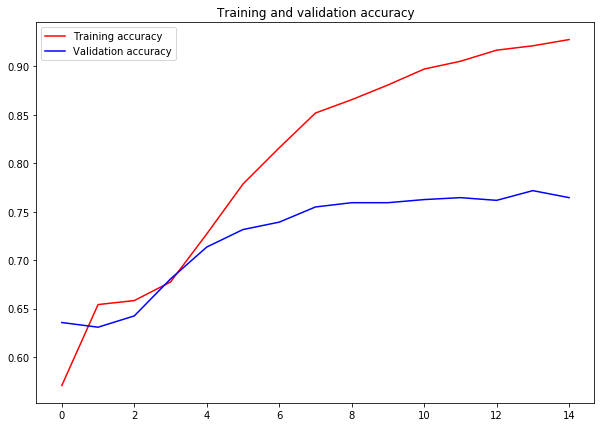

<Figure size 432x288 with 0 Axes>

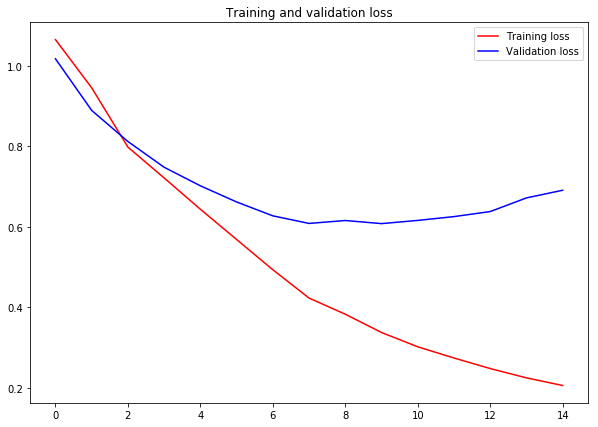

<Figure size 432x288 with 0 Axes>

In [30]:
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
history2 = model2.history
acc=history2.history['acc']
val_acc=history2.history['val_acc']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy','Validation accuracy'])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.legend(['Training loss','Validation loss'])
plt.figure()
max(val_acc) #the best validation accuracy the model have got

In [31]:
accuracy2 = model2.evaluate(test_X_seq, Y_test)
print("accuracy of Embedding GRU model: " + str(accuracy2[1]))

2196/2196 [==============================] - 18s 8ms/step
accuracy of Embedding GRU model: 0.7764116577763375


In [32]:
result_df = pd.DataFrame([{'RNN':accuracy2[1],'Conv1D':accuracy1[1],'Naive Bayes':acc_nb_cv,'SVM':acc_cv_svm}])

below DataFrame contains every model crosseponding to its accuracy

In [33]:
result_df

,Conv1D,Naive Bayes,RNN,SVM
0,0.758652,0.798725,0.776412,0.623406


conluding that Naive Bayes model gave the best results so here is the confusion matrix and classification report for this model .

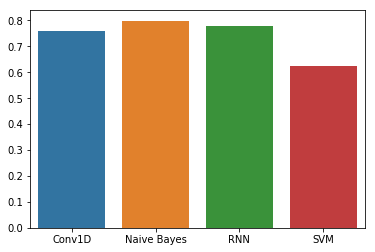

In [47]:
sns.barplot(x=result_df.columns,y=result_df.values[0])

In [34]:
from sklearn import metrics
print("Classification report  \n%s\n"
      % ( metrics.classification_report(Y_test, clfrNB.predict(vect.transform(X_test)))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(Y_test,clfrNB.predict(vect.transform(X_test))))

Classification report  
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1369
           1       0.73      0.52      0.61       496
           2       0.71      0.71      0.71       331

    accuracy                           0.80      2196
   macro avg       0.76      0.72      0.73      2196
weighted avg       0.79      0.80      0.79      2196


Confusion matrix:
[[1263   68   38]
 [ 180  257   59]
 [  69   28  234]]
